# Preparació de les dades d'entrenament

En aquest notebook es duran a terme les següents tasques:
- Divisió dels subconjunts de dades (entrenament i prova)
- Codificació de les variables categòriques
- Estandardització de les característiques
- Reducció de la dimensionalitat del conjunt de dades

Es parteix de la base d'un dataset bank_dataset_sprint5.csv que ja ha estat tractat amb un EDA previ, resultat de l'Sprint 5. A l'Sprint 5 havíem realitat algunes codificacions de variables categòriques que en realitat corresponen a l'Sprint actual, així que hem decidit guardar les dades ABANS de realitzar aquests tractaments en conflicte. En aquest cas, es realitzarà un tractament de les dades per tal de preparar-les per a l'entrenament dels models de machine learning.

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

In [2]:
# carreguem el dataset
data = pd.read_csv('data/bank_dataset_sprint5.csv')

print("Nombre de registres: ", len(data))
print(data.head())

Nombre de registres:  10098
    age         job  marital  education default  balance housing loan  \
0  59.0      admin.  married  secondary      no     2343     yes   no   
1  41.0  technician  married  secondary      no     1270     yes   no   
2  55.0    services  married  secondary      no     2476     yes   no   
3  54.0      admin.  married   tertiary      no      184      no   no   
4  42.0  management   single   tertiary      no        0     yes  yes   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  
0  unknown    5   may      1042         1     -1         0  unknown     yes  
1  unknown    5   may      1389         1     -1         0  unknown     yes  
2  unknown    5   may       579         1     -1         0  unknown     yes  
3  unknown    5   may       673         2     -1         0  unknown     yes  
4  unknown    5   may       562         2     -1         0  unknown     yes  


## Divisió dels subconjunts d'entrenament i prova

Un cop carregat el dataset es divideix en dos subconjunts: un per a l'entrenament del model i un altre per a la seva validació. El percentatge de dades dedicades a l'entrenament i a la prova (normalment 70-80% per entrenament i 20-30% per prova) s'estableix per garantir que el model disposi de prou dades per aprendre patrons sense sobreajustar-se, alhora que es reserva una porció significativa per avaluar-ne el rendiment de manera objectiva i representativa. En aquest cas, reservarem un 75% de les dades per a l'entrenament i un 25% per a la validació, quedant 8371 i 2791 registres, respectivament.

A més a més, utilitzarem el paràmetre `stratify`, vinculat a la variable objectiu, per tal de mantenir la proporció de les classes en els dos subconjunts. Comprovarem visualment que aquesta proporció s'ha mantingut.

In [3]:
# separem les variables explicatives i la variable objectiu
X = data.drop(columns=['deposit'])
y = data['deposit']

# dividim el conjunt de dades amb el paràmetre stratify vinculat a la variable objectiu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# mostrem la distribució de la variable objectiu en els dos subconjunts
y_train_distribution = y_train.value_counts(normalize=True)
y_test_distribution = y_test.value_counts(normalize=True)

print("Distribució de la variable objectiu en el conjunt d'entrenament: ", y_train_distribution)
print("Nombre de registres en el conjunt d'entrenament: ", len(y_train))
print("")
print("Distribució de la variable objectiu en el conjunt de test: ", y_test_distribution)
print("Nombre de registres en el conjunt de test: ", len(y_test))

Distribució de la variable objectiu en el conjunt d'entrenament:  deposit
no     0.543906
yes    0.456094
Name: proportion, dtype: float64
Nombre de registres en el conjunt d'entrenament:  7573

Distribució de la variable objectiu en el conjunt de test:  deposit
no     0.544158
yes    0.455842
Name: proportion, dtype: float64
Nombre de registres en el conjunt de test:  2525


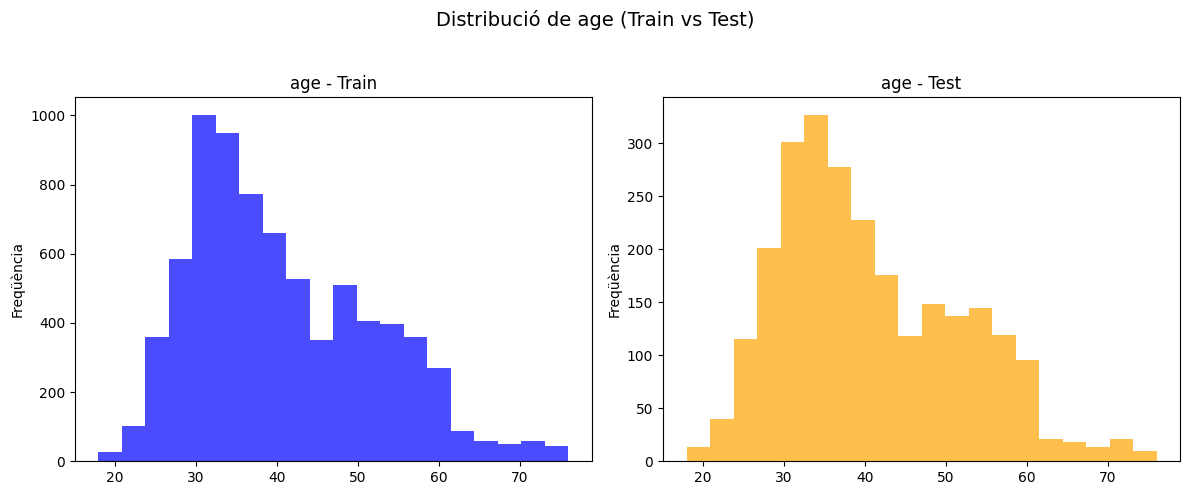

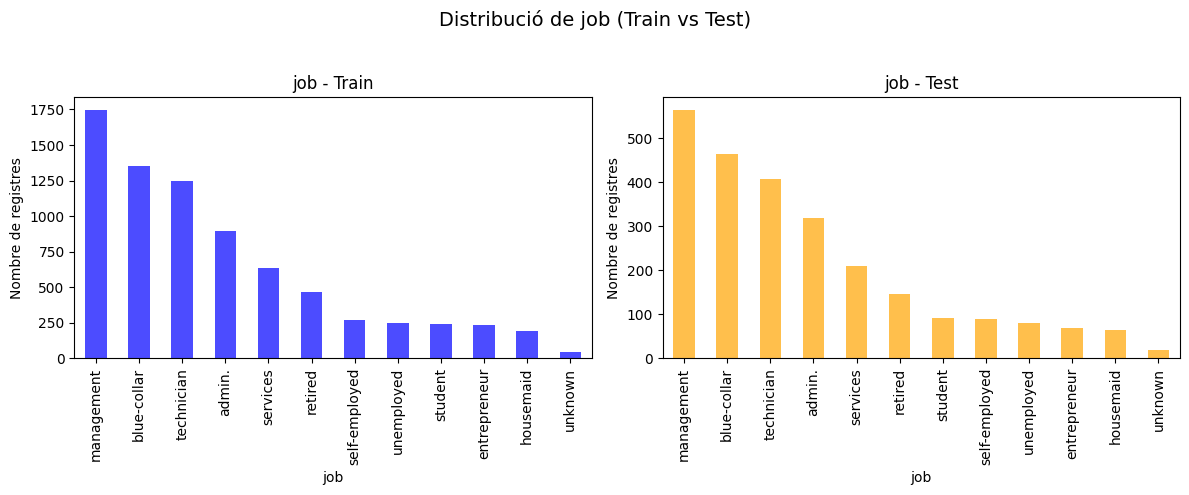

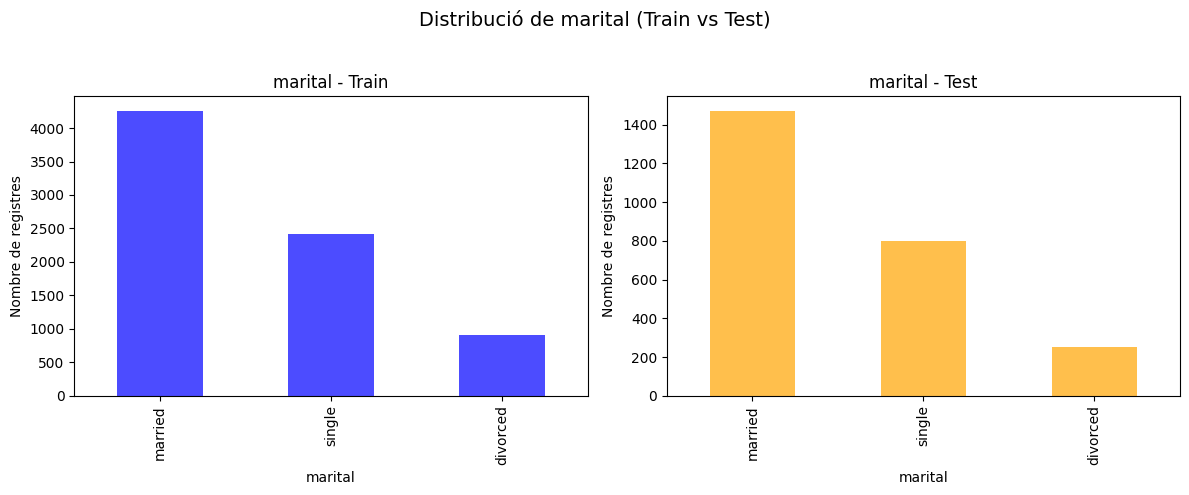

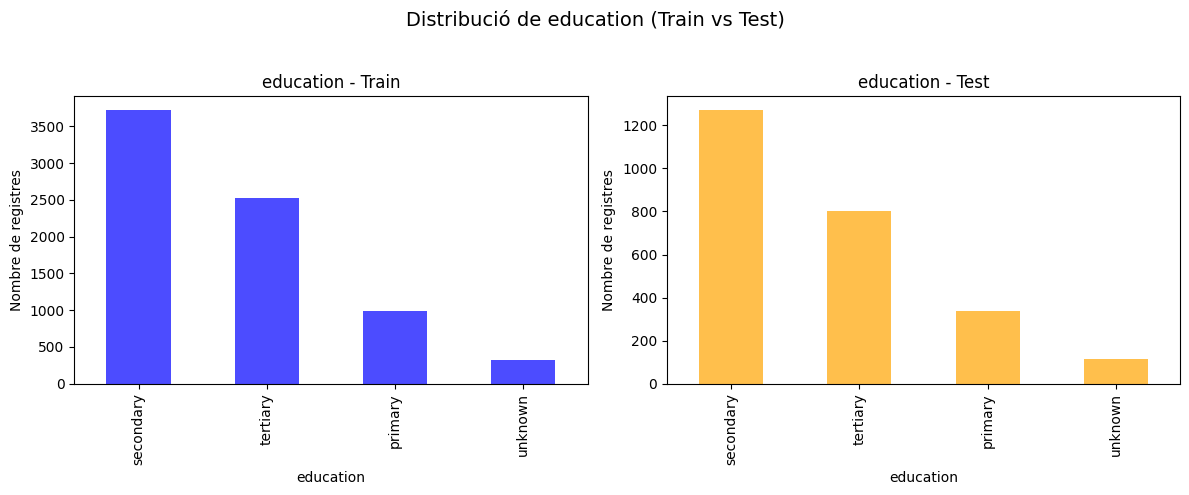

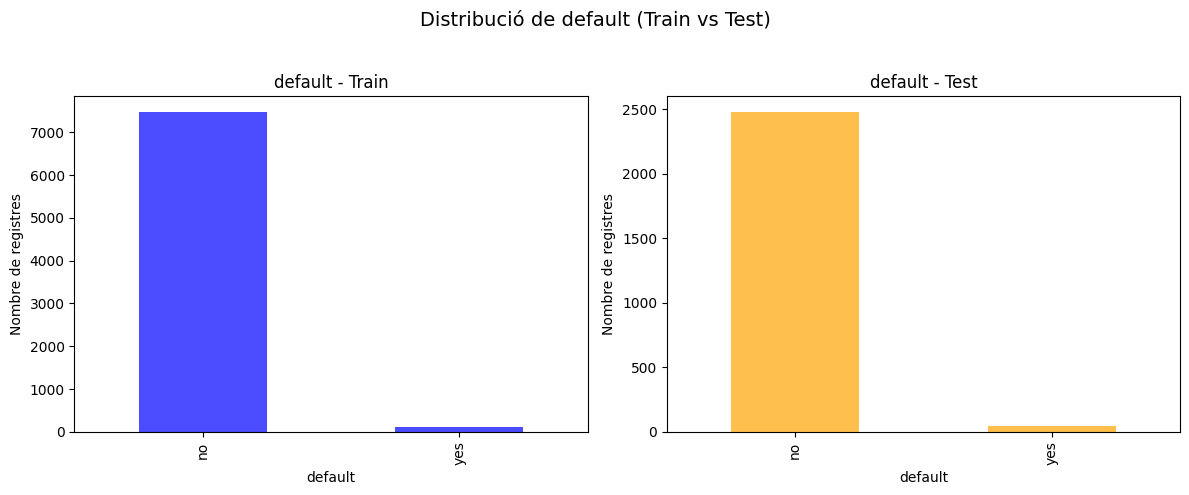

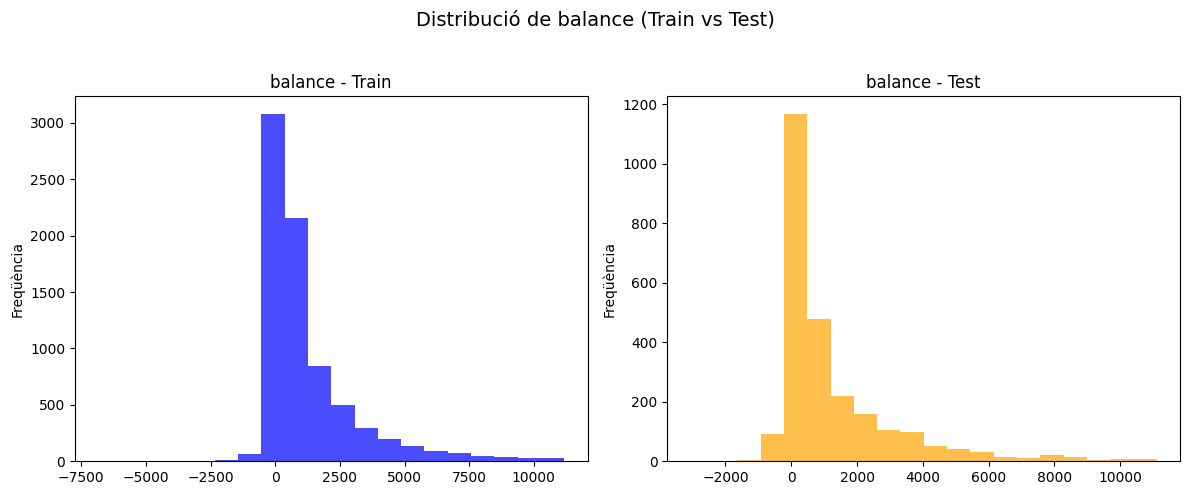

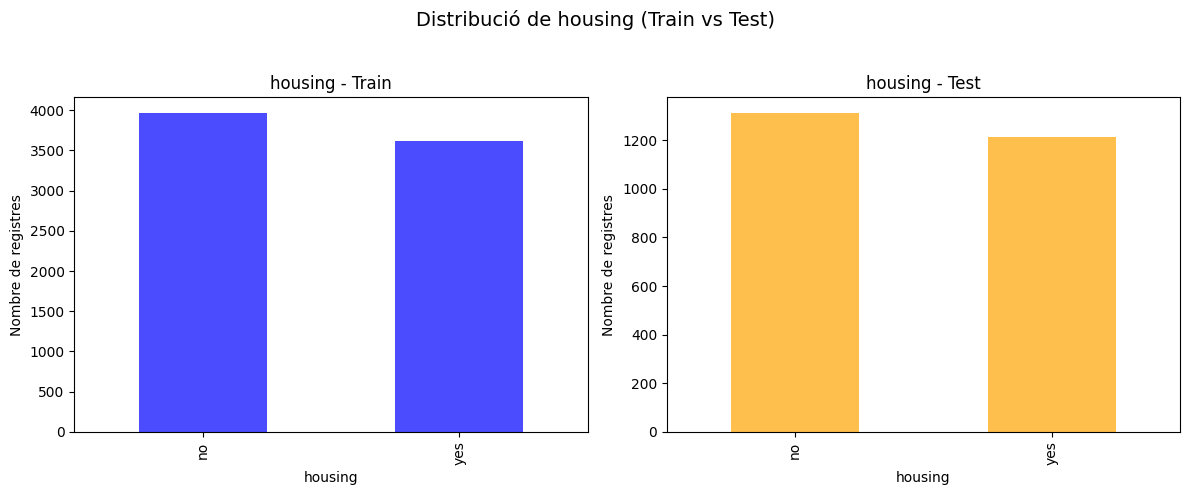

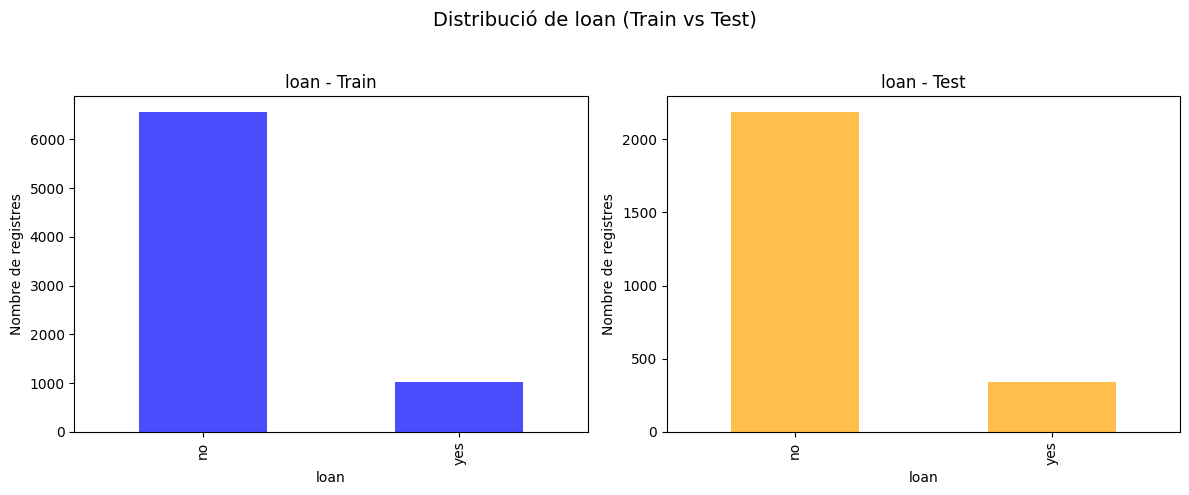

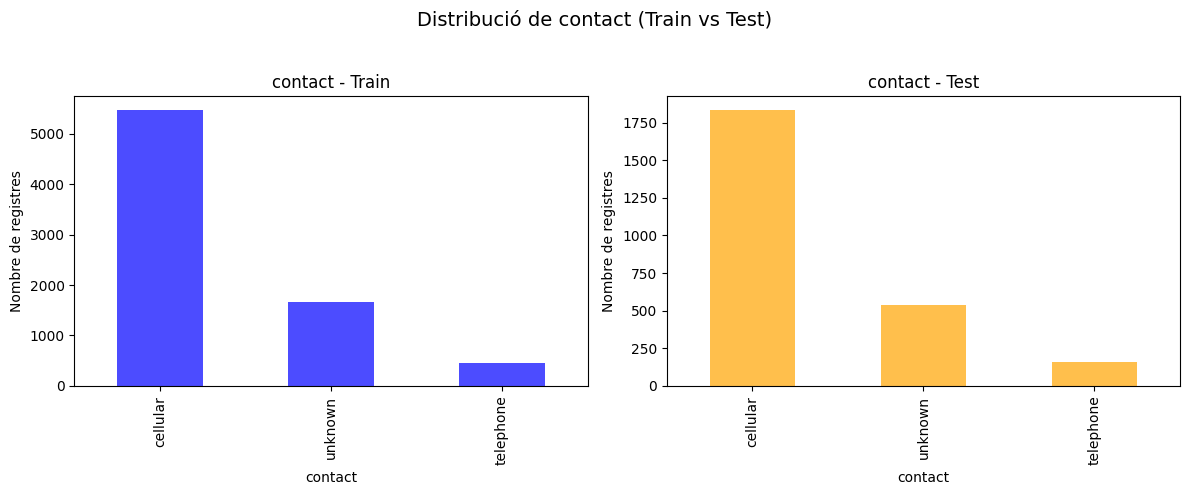

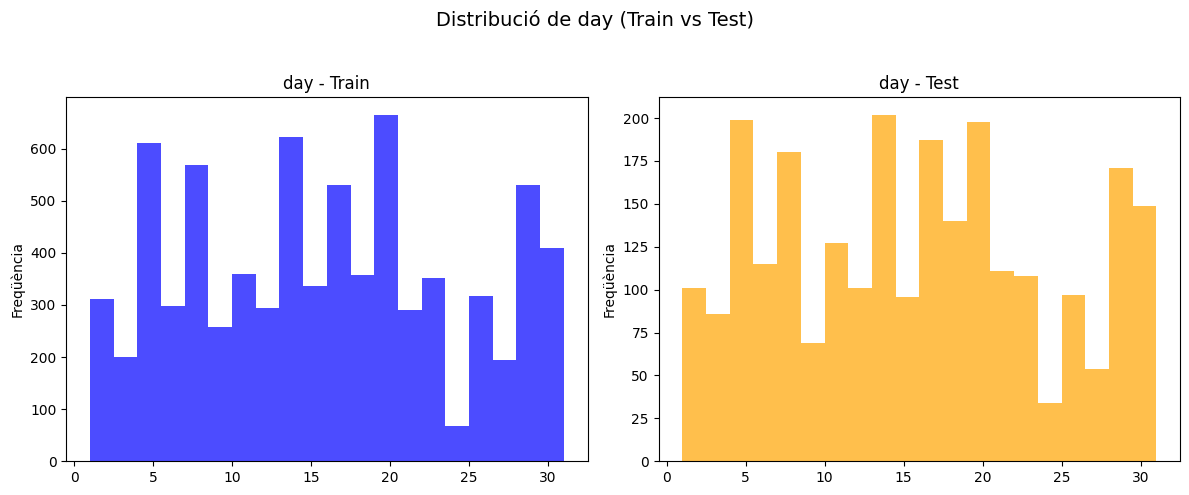

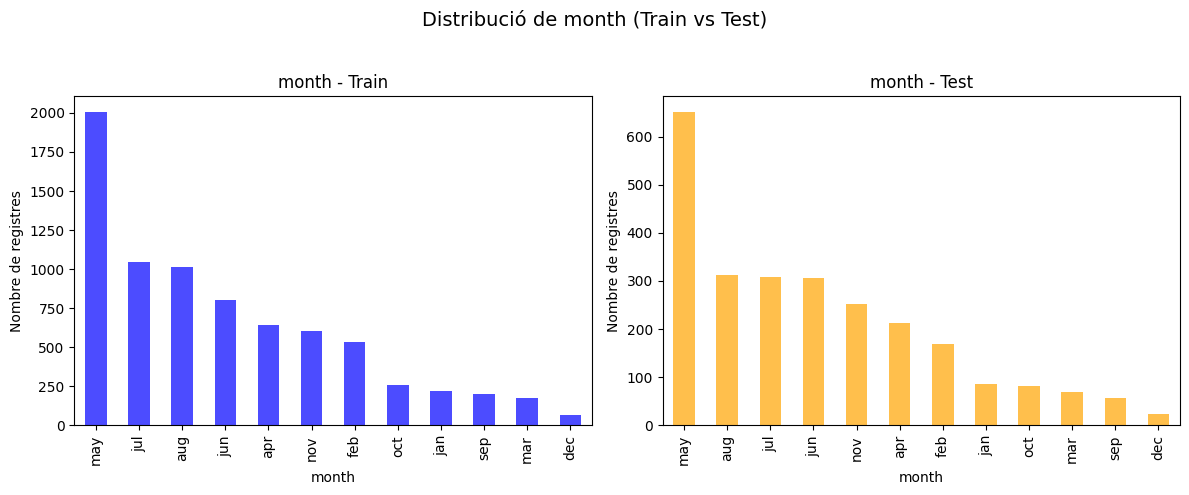

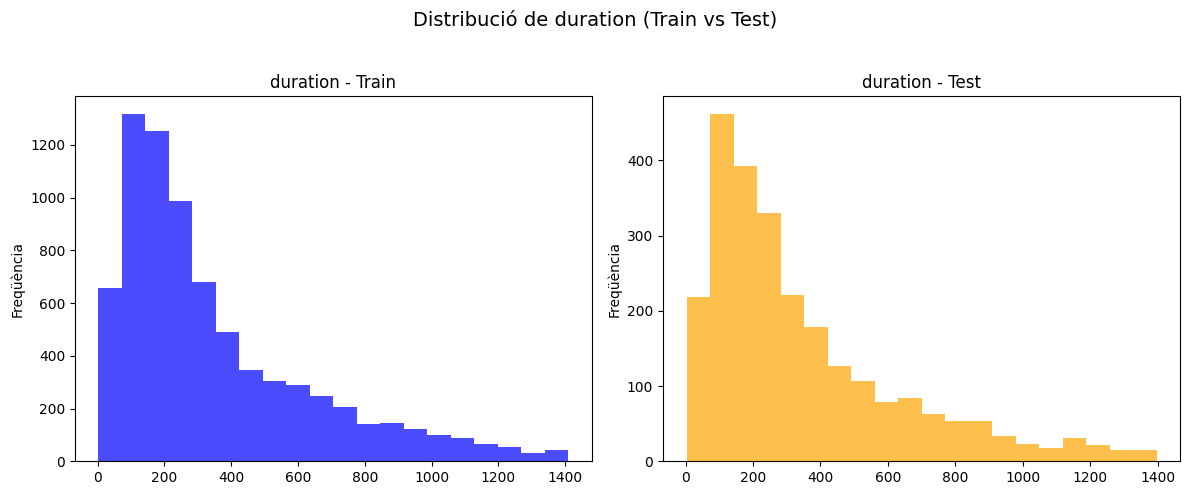

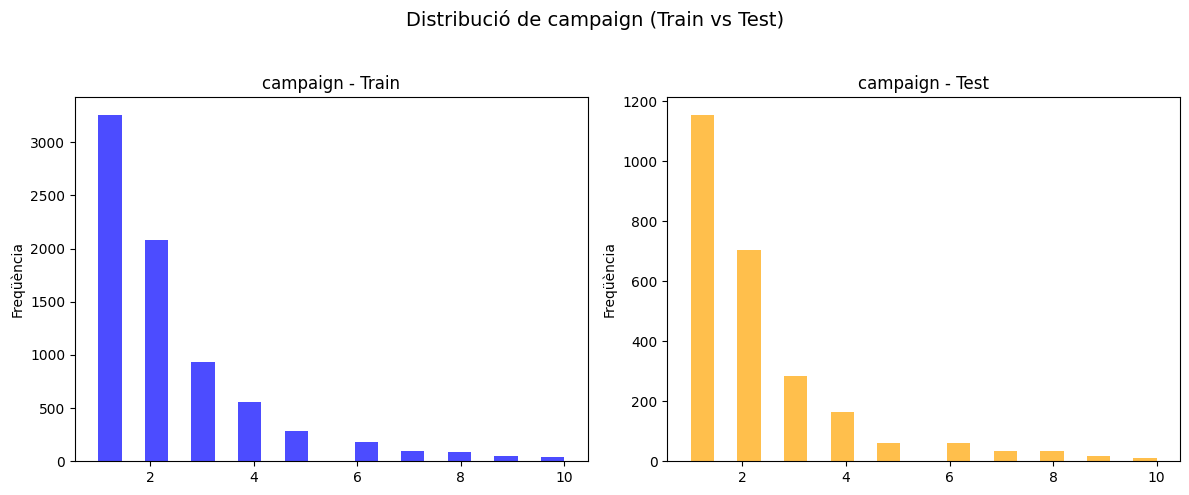

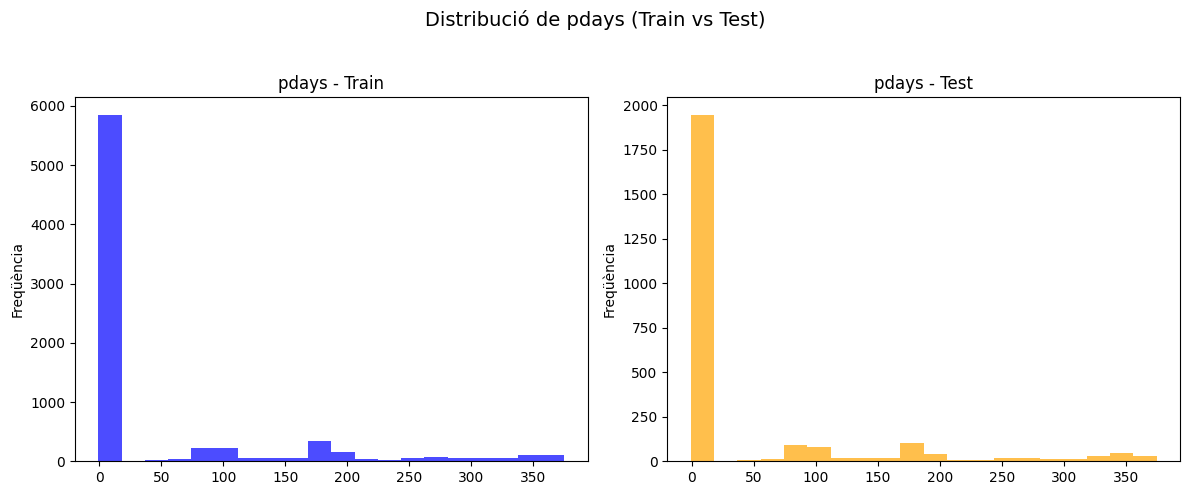

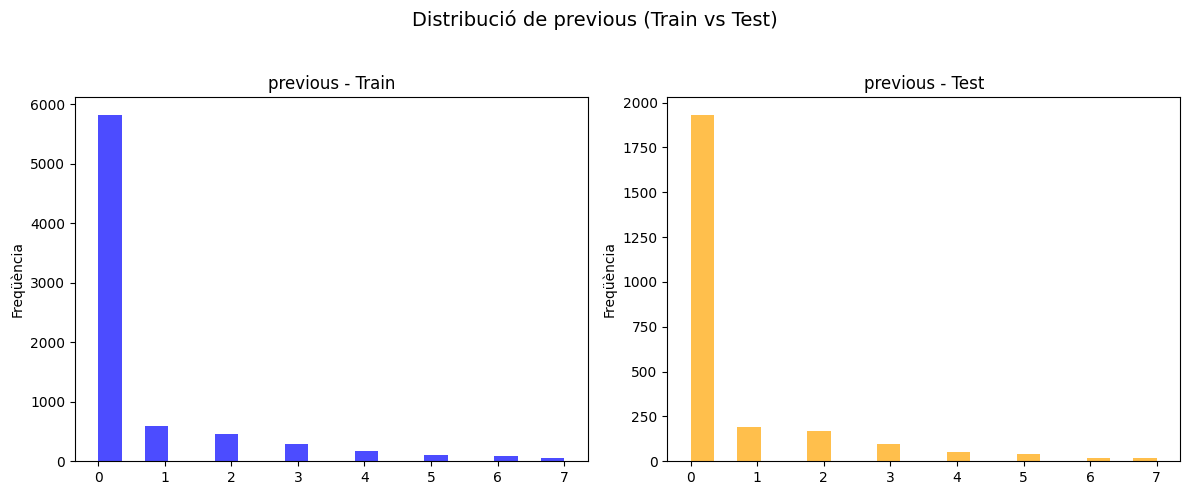

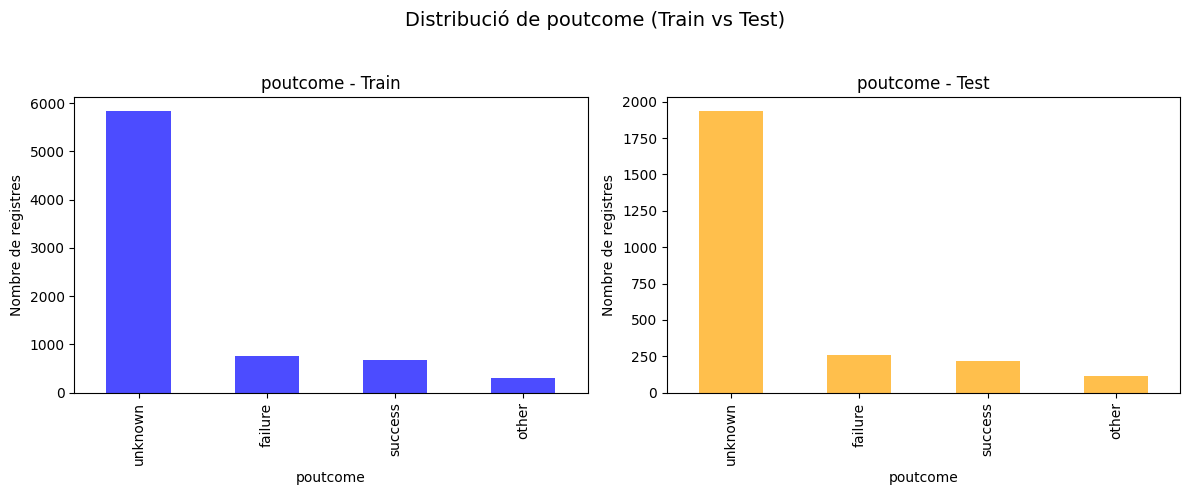

In [4]:
# separem les variables numèriques i categòriques
numeric_columns = X.select_dtypes(include=['number']).columns
categorical_columns = X.select_dtypes(exclude=['number']).columns

# visualitzem com queden distribuïdes totes les variables en els dos subconjunts
for column in X.columns:
    plt.figure(figsize=(12, 5))
    if column in numeric_columns:
        plt.subplot(1, 2, 1)
        plt.hist(X_train[column], bins=20, alpha=0.7, color='blue')
        plt.title(f'{column} - Train')
        plt.ylabel('Freqüència')

        plt.subplot(1, 2, 2)
        plt.hist(X_test[column], bins=20, alpha=0.7, color='orange')
        plt.title(f'{column} - Test')
        plt.ylabel('Freqüència')

    else:
        plt.subplot(1, 2, 1)
        X_train[column].value_counts().plot(kind='bar', alpha=0.7, color='blue')
        plt.title(f'{column} - Train')
        plt.ylabel('Nombre de registres')

        plt.subplot(1, 2, 2)
        X_test[column].value_counts().plot(kind='bar', alpha=0.7, color='orange')
        plt.title(f'{column} - Test')
        plt.ylabel('Nombre de registres')

    plt.suptitle(f'Distribució de {column} (Train vs Test)', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Podem veure que, en general, totes les variables dels subsets d'entrenament i prova tenen una distribució molt similar. 

**NOTA**: Hem decidit no crear un subconjunt de validació separat. La previsió és implementar models com la Regressió Logística, Random Forest o Gradient Boosting utilitzant la validació creuada. La validació creuada divideix efectivament les dades d'entrenament en diversos blocs (folds), permetent que cada bloc actuï com un conjunt de validació temporal mentre s'entrena amb la resta de les dades. Aquest enfocament proporciona una sintonització robusta dels hiperparàmetres i una avaluació del rendiment sense haver de reservar una part específica de les dades per a validació. Així, la validació creuada maximitza l'ús del conjunt de dades disponible i redueix la necessitat d'un subconjunt de validació separat.

## Codificació de les variables categòriques

En aquest apartat aplicarem **One Hot Encoding** a les variables categòriques i **Label Encoding** a les binàries. El one-hot encoding és una tècnica utilitzada per transformar variables categòriques amb múltiples opcions en un format numèric que els models d'aprenentatge automàtic poden entendre. Aquesta tècnica crea una nova columna per a cada categoria i assigna el valor 1 a la columna corresponent a la categoria de la fila, mentre que a la resta s'assigna 0. En canvi, el label encoding s'utilitza principalment per variables binàries i assigna valors numèrics, com 0 i 1, a les dues opcions. Mentre que el one-hot encoding és més adequat per a variables amb múltiples categories sense ordre inherent, el label encoding és més senzill i es reserva per a variables amb només dues opcions.

In [5]:
# obtenim les variables binàries
binary_columns = [column for column in X.columns if X[column].nunique() == 2]
# obtenim les variables categòriques amb més de 2 categories
categorical_columns = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique() > 2]

print("Variables binàries: ", binary_columns)
print("Variables categòriques: ", categorical_columns)
print("Variables numèriques: ", list(numeric_columns))

Variables binàries:  ['default', 'housing', 'loan']
Variables categòriques:  ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
Variables numèriques:  ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [6]:
# apliquem one-hot encoding a les variables categòriques als dos subsets
X_train = pd.get_dummies(X_train, columns=categorical_columns, dtype=int)
X_test = pd.get_dummies(X_test, columns=categorical_columns, dtype=int)

print("Nombre de variables després de l'aplicació de one-hot encoding: ", len(X_train.columns))

# mostrem les variables després de l'aplicació de one-hot encoding
print("Variables després de l'aplicació de one-hot encoding: ", [col for col in X_train.columns])

Nombre de variables després de l'aplicació de one-hot encoding:  48
Variables després de l'aplicació de one-hot encoding:  ['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


In [7]:
# apliquem el label encoding a les variables binàries
label_encoder = LabelEncoder()
for column in binary_columns:
    X_train[column] = label_encoder.fit_transform(X_train[column])
    X_test[column] = label_encoder.transform(X_test[column])

In [8]:
# mostrem les dades després de la transformació
print(X_train.head())

       age  default  balance  housing  loan  day  duration  campaign  pdays  \
3334  34.0        0        0        0     0   30       292         1    183   
8099  36.0        0        0        0     0   15       794         1     -1   
2507  76.0        0     1411        0     0   19       233         2    187   
8476  41.0        0       80        0     0   19       202         1     -1   
5041  31.0        0      379        1     0   18       570         2     -1   

      previous  ...  month_jun  month_mar  month_may  month_nov  month_oct  \
3334         2  ...          0          0          0          0          0   
8099         0  ...          0          0          0          0          0   
2507         3  ...          0          0          0          0          1   
8476         0  ...          0          0          0          1          0   
5041         0  ...          0          0          0          0          0   

      month_sep  poutcome_failure  poutcome_other  poutc

In [9]:
# apliquem el label encoding a la variable objectiu
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

## Estandardització de les característiques

En aquest apartat estandaritzarem les variables del dataset. Per als models que aplicarem, l'estandardització és essencial per a la Regressió Logística, ja que es tracta d'un model lineal sensible a l'escala de les característiques, especialment quan incloem regularització. En canvi, per a Random Forest i Gradient Boosting, no és necessari estandarditzar, ja que són models basats en arbres que gestionen cada característica de manera independent de la seva escala. Tot i així, aplicar l’estandardització no perjudicarà aquests models i podría ser útil si els combinem amb altres models sensibles a l’escala en un pipeline.

Primerament estandaritzarem les variables numèriques al subset de dades d'entrenament i després aplicarem la mateixa transformació al subset de dades de prova. Això és important per garantir que les dades de prova no es veuran involucrades en la transformació de les dades d'entrenament, evitant així la fuga d'informació.

In [10]:
# apliquem l'estandarització a les variables numèriques
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

print(X_train.head())

           age  default   balance  housing  loan       day  duration  \
3334 -0.601936        0 -0.672196        0     0  1.720881 -0.199912   
8099 -0.423558        0 -0.672196        0     0 -0.066658  1.520295   
2507  3.144011        0  0.096054        0     0  0.410019 -0.402088   
8476  0.022389        0 -0.628639        0     0  0.410019 -0.508316   
5041 -0.869504        0 -0.465841        1     0  0.290850  0.752713   

      campaign     pdays  previous  ...  month_jun  month_mar  month_may  \
3334 -0.747537  1.533708  1.055367  ...          0          0          0   
8099 -0.747537 -0.476021 -0.443141  ...          0          0          0   
2507 -0.158576  1.577398  1.804621  ...          0          0          0   
8476 -0.747537 -0.476021 -0.443141  ...          0          0          0   
5041 -0.158576 -0.476021 -0.443141  ...          0          0          0   

      month_nov  month_oct  month_sep  poutcome_failure  poutcome_other  \
3334          0          0         

## Reducció de la dimensionalitat del conjunt de dades

En aquest apartat estudiarem l'aplicació de la tècnica de **PCA (Principal Component Analysis)** per reduir la dimensionalitat del conjunt de dades. Quan hi ha dades amb moltes dimensions, els algoritmes d'anàlisi o modelatge poden ser més lents o menys eficients. El PCA ajuda a reduir la dimensionalitat i, així, a millorar el rendiment computacional dels models, evitant també el sobreajustament. Aquesta tècnica transforma les característiques originals en un nou conjunt de característiques no correlacionades (components principals) que expliquen la major part de la variabilitat del conjunt de dades. Així, els components principals són combinacions lineals de les característiques originals que conserven la informació més rellevant del conjunt de dades.

Evitarem la utilització de la variable `duration`, ja que aquesta variable no està disponible abans de realitzar la trucada i, per tant, no és útil per predir si un client subscriurà un dipòsit a terme. Així doncs, eliminarem aquesta variable abans d'aplicar PCA. A més a més, també eliminarem la variable vinculada al canal de contacte desconegut `contact_unknown`, ja que el comercial sap quin és el canal de contacte i per tant aquesta variable no té sentit per a la predicció.

In [11]:
# eliminem les variables que no aporten informació: duration i contact_unknown
X_train = X_train.drop(columns=['duration', 'contact_unknown'])
X_test = X_test.drop(columns=['duration', 'contact_unknown'])

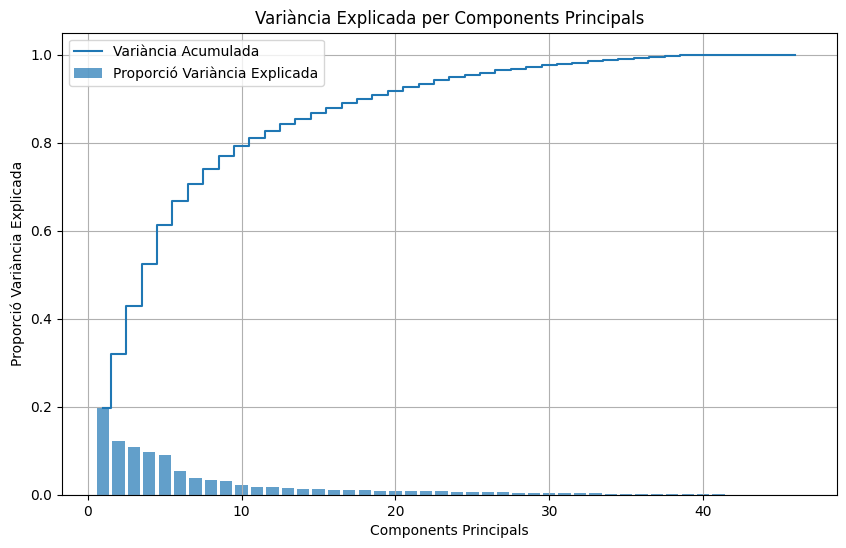

Nombre de components principals per aconseguir el 80% de la variància explicada:  10
Nombre de components principals per aconseguir el 90% de la variància explicada:  18


In [23]:
# apliquem un PCA al conjunt de dades
pca = PCA()
pca.fit(X_train)

# calculem la proporció de variància explicada per cada component
explained_variance_ratio = pca.explained_variance_ratio_

# creem un DataFrame per mostrar la proporció de variància explicada per component
explained_variance_df = pd.DataFrame({
    'Component Principal': [f'CP{i+1}' for i in range(len(explained_variance_ratio))],
    'Proporció Variància Explicada': explained_variance_ratio
})

# afegim una columna de variància acumulada
explained_variance_df['Variància Acumulada'] = explained_variance_df['Proporció Variància Explicada'].cumsum()

# representem gràficament la proporció de variància explicada i la variància acumulada
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Proporció Variància Explicada')
plt.step(range(1, len(explained_variance_ratio) + 1), explained_variance_df['Variància Acumulada'], where='mid', label='Variància Acumulada')

plt.xlabel('Components Principals')
plt.ylabel('Proporció Variància Explicada')
plt.title('Variància Explicada per Components Principals')
plt.legend()
plt.grid(True)
plt.show()

# numero de components principals per aconseguir el 80% de la variància explicada
n_components_80 = (explained_variance_df['Variància Acumulada'] <= 0.8).sum()
print("Nombre de components principals per aconseguir el 80% de la variància explicada: ", n_components_80)

# numero de components principals per aconseguir el 90% de la variància explicada
n_components_90 = (explained_variance_df['Variància Acumulada'] <= 0.9).sum()
print("Nombre de components principals per aconseguir el 90% de la variància explicada: ", n_components_90)

Un cop aplicat el PCA, podem veure que un cop obtinguts els components principals, el 80% de la variabilitat del conjunt de dades es conserva en els primers 10 components i el 90% en els 18 primers components. Utilitzarem aquests 18 components principals, permetent reduir la dimensionalitat del conjunt de dades sense perdre gaire informació.

In [22]:
# apliquem PCA amb 18 components principals
pca = PCA(n_components_90)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# mostrem les dades després de l'aplicació de PCA
print("Dades després de l'aplicació de PCA: ")
print(pd.DataFrame(X_train_pca).head())

Dades després de l'aplicació de PCA: 
         0         1         2         3         4         5         6   \
0  1.797173 -0.462109  1.377542 -0.006761 -1.650640  0.738424  0.081285   
1 -0.605660 -0.668424 -0.547064 -0.365517 -0.607651 -0.299625 -0.475468   
2  2.296198  2.876949  0.143670 -1.323415 -0.984070  0.225978 -0.308892   
3 -0.608032 -0.243293 -0.329764 -0.344535 -1.000473 -0.181123 -0.656987   
4 -0.694868 -1.260738  0.214804  0.198849 -0.232115 -0.268300 -0.548652   

         7         8         9         10        11        12        13  \
0  0.393863 -0.778544  0.258194 -0.215358 -0.554954  0.299396 -0.006003   
1  0.597641 -0.772916  0.502601  0.303824 -0.267705 -0.091224 -0.031272   
2 -0.907322  1.319620  0.820129 -0.239503 -0.267559  0.433003  0.566158   
3  0.361062 -0.688644 -0.166523 -0.196196 -0.337536 -0.373244  0.017100   
4 -0.295034  0.016911 -0.148237  0.649817 -0.327851  0.211954 -0.532786   

         14        15        16        17  
0  0.736116  0.6

## Conclusions

En aquest notebook s'han preparat les dades per a l'entrenament dels models de machine learning, seguint una sèrie de passos estructurats i amb una base metodològica sòlida. A continuació es resumeixen els aspectes més rellevants:

1. **Divisió del conjunt de dades:**
   - El dataset s'ha dividit en subconjunts d'entrenament (75%) i prova (25%) utilitzant estratificació en la variable objectiu per mantenir la proporcionalitat de les classes. Això assegura una avaluació justa del model i garanteix que la distribució de classes sigui representativa en ambdós subconjunts.

2. **Codificació de variables categòriques i binàries:**
   - S'ha aplicat **one-hot encoding** a les variables categòriques amb més de dues categories, augmentant el nombre de variables del conjunt de dades.
   - S'ha utilitzat **label encoding** per les variables binàries i la variable objectiu, assignant 0 i 1 als seus valors.

3. **Estandardització de les variables:**
   - Les variables numèriques s'han estandaritzat per tenir mitjana 0 i desviació estàndard 1. Això és essencial per als models lineals com la Regressió Logística i també assegura que totes les variables contribueixin de manera equitativa en l'anàlisi de components principals (PCA).

4. **Eliminació de variables no informatives:**
   - S'han eliminat les variables `duration` i `contact_unknown` perquè no aporten informació útil per a la predicció del model en situacions reals. Aquesta decisió s'ha pres després de considerar la seva aplicabilitat en el context del problema.

5. **Reducció de dimensionalitat amb PCA:**
   - S'ha aplicat PCA per reduir la dimensionalitat del conjunt de dades. El gràfic de variància explicada ha mostrat que els primers 18 components principals expliquen aproximadament el 90% de la variabilitat del conjunt de dades.
   - La selecció d’aquests 18 components (en comparació a les 48 variables abans del PCA) permet conservar la major part de la informació rellevant mentre es redueix significativament la complexitat computacional i es minimitza el risc de sobreajustament.

### **Implicacions i propers passos**
- Les dades estan llestes per ser utilitzades en models de machine learning. Els models seleccionats (Regressió Logística, Random Forest i Gradient Boosting) es beneficiaran del preprocés realitzat, que maximitza la seva eficàcia i eficiència.
- La validació creuada serà clau per ajustar els hiperparàmetres dels models i garantir una generalització òptima.
- La reducció de dimensionalitat amb PCA és especialment útil per als models sensibles a la multicol·linealitat i també simplifica la interpretació dels patrons més importants en les dades.

Aquest procés garanteix una preparació robusta i adequada de les dades per aconseguir bons resultats en la fase de modelatge.